In [ ]:
! pip install yahoo_fin> NUL

In [ ]:
import numpy as np
import pandas as pd
import datetime
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf
from scipy.stats import multivariate_normal
import yfinance as yf
from yahoo_fin import stock_info as si

def data_generate_setting3(p, T, D, n_components=2, start_date=datetime.datetime(2016,1,3), end_date=datetime.datetime(2019,12,31), seed=1234):
    """
    Generates a dataset based on time-varying covariance matrix estimated with factor models. Factor loading mimicking the S&P 500 daily data.
    For this DGPs, the factor loadings are calibrated from daily stock returns of the component stocks listed in the S&P 500 index. Stocks are randomly
    selected for different portfolio sizes. We apply the local principal component method to compute the time-varying factor loadings and common factor estimators.
    Copyright (C) 2023 Ali Habibnia <habibnia@vt.edu> & Jalal Etesam

    Args:
      p: Dimension of the portfolio.
      T: Sample size.
      D: The length of each step in the factor loadings.
      n_components: Number of principal components to retain. Default is 2.
      start_date: Start date for stock data retrieval. Default is January 3, 2016.
      end_date: End date for stock data retrieval. Default is December 31, 2019.
      seed: Random seed for reproducibility. Default is 1234.

    Returns:
      DataFrame: Generated dataset based on principal components of the chosen stocks' returns.

    Reference:
      Qingliang Fan, Ruike Wu, Yanrong Yang, Wei Zhong,
      Time-varying minimum variance portfolio,
      Journal of Econometrics,
      2022,
      105339,
      ISSN 0304-4076,
      https://doi.org/10.1016/j.jeconom.2022.08.007.
      (https://www.sciencedirect.com/science/article/pii/S0304407622001646
    """

    np.random.seed(seed)

    # Burn-in period
    T_adjusted = T + 200

    # Download the S&P 500 tickers
    tickers = si.tickers_sp500()
    tickers = [item.replace(".", "-") for item in tickers]  # Formatting ticker names

    # Randomly select 'p' tickers
    selected_tickers = np.random.choice(tickers, p, replace=False)

    # Download stock data for the selected tickers
    stock_data = yf.download(selected_tickers.tolist(), start=start_date, end=end_date)['Adj Close']
    stock_data_cleaned = stock_data.dropna(axis='columns', how='any')

    # If some stocks fail to download, fetch more until we have 'p' stocks
    while stock_data_cleaned.shape[1] < p:
        additional_tickers_needed = p - stock_data_cleaned.shape[1]
        remaining_tickers = list(set(tickers) - set(selected_tickers))
        additional_tickers = np.random.choice(remaining_tickers, additional_tickers_needed, replace=False)
        additional_data = yf.download(additional_tickers.tolist(), start=start_date, end=end_date)['Adj Close']

        stock_data_cleaned = pd.concat([stock_data_cleaned, additional_data], axis=1)
        stock_data_cleaned = stock_data_cleaned.dropna(axis='columns', how='any')
        selected_tickers = list(stock_data_cleaned.columns)

    # Compute log returns from the stock prices
    stock_returns = np.log(stock_data_cleaned / stock_data_cleaned.shift(1)).dropna()

    # Determine the number of steps based on the adjusted T and D
    k = T_adjusted // D

    # Initialize a matrix for storing the generated data
    Y = np.zeros((T_adjusted, p))

    # Generate data based on the PCA decomposition for each step
    for step in range(k):
        step_data = stock_returns.iloc[step*D:(step+1)*D]

        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(step_data)

        residuals = step_data - pca.inverse_transform(principal_components)

        # a sparse covariance estimator of idiosyncratic residual can be obtained by applying shrinkage estimator.
        shrinkage = LedoitWolf()
        s_cov_step = shrinkage.fit(residuals).covariance_

        # Compute the contribution from the factors
        fa_part = principal_components.dot(pca.components_)

        # Generate the residuals
        x_k = multivariate_normal.rvs(mean=np.zeros(p), cov=s_cov_step, size=D).T

        # Combine factor contributions and residuals to generate the data
        Y[step*D:(step+1)*D] = fa_part + x_k.T

    # We remove the first 200 observations to account for the potential non-stationarity caused by the initial conditiyty
    Y_df = pd.DataFrame(Y[200:])
    return Y_df

In [ ]:
# Example usage with specific values for p, T, and D
p = 50
T = 500
D = 50
returns = data_generate_setting3(p, T, D)
returns.head(3)

[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  1 of 1 completed


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.008629,-0.012802,-0.003698,-0.010632,0.000385,-0.001914,-0.007953,-0.005891,-0.019060,-0.011721,...,-0.004567,-0.005906,0.010755,0.005676,0.003499,-0.008933,-0.007745,-0.003213,-0.015419,-0.000449
1,-0.010563,0.017803,0.025474,-0.011393,-0.008115,0.010328,0.025097,0.003462,0.008362,-0.024112,...,-0.009766,-0.002441,0.007015,-0.000709,0.018525,-0.021773,-0.018098,0.006592,0.019811,-0.001071
2,-0.014641,-0.005694,-0.006777,-0.037379,-0.015152,-0.007243,-0.023528,0.012092,-0.001092,-0.029440,...,0.021590,-0.004048,0.000204,-0.006485,-0.002581,-0.024432,-0.012544,0.000108,0.008767,-0.018131


<Axes: >

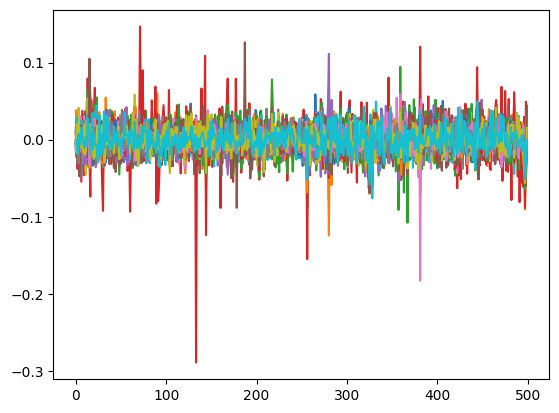

In [ ]:
returns.plot(legend = False)